# Chest X-Ray Analysis Using Apache Spark (PySpark) - Model Evaluation Analysis

## Introduction
The project leverage Apache Spark to process and analyze a **Chest X-Ray dataset**, which contains labeled images across four categories: **Normal, Pneumonial, Yuberculosis,** and **Covid-19**. This dataset serves as a valuable resource for exploring the application of **big data tools** in medical imaging, especially in the early detection respiratory diseases.

## Objective 
THe primary aim is to utilize Spark's capabilities to perform scalable and efficient processing of this medical imaging dataset, Key objectives include:
1. **Data Processing:** Cleaning and transform the dataset into a format suitable for analysis.
2. **Exploratory Data Analysis (EDA):** Generate insiights on class distributions, image dimensions, and other metadata.
3. **Feature Extraction:** Apply feature engineering techniques to perpare the data for machine learning models.
4. **Model Training:** IMplement a distributed pipeline to classify chest X-rays into the four categories using three machine learning models from TensorFlow and PyTorch, VGG19, ResNet-101 and EfficientNetB2.
5. **Performance Evaluation:** Showcase the performance of each of the models measured by different matrices to identify the best classification model for the dataset.
6. **Grad-CAM Model Interpretation**: Performing model interpretation on the predicted classifications using Heatmap identification of high classification concentrated areas.

## Initializing Spark

In [1]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("ImageRecognition") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "8g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

print(spark)


## Accessing Image Directory

In [ ]:
import os

input_dir = "Chest X_Ray Dataset"

# List all files under the input directory
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Create a dataframe with images and their Classification Category
To better analyze the image data, creating a dataset with variables **image_path** and **category** to identify each image to its given category in a tabular form gives a much satisfying visualization of the data. In this section, we will do further inspection on the dataset - testing validation, duplication, categorical counts and more.

In [9]:
dataset_path = "Chest X_Ray Dataset"
categories_list = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

# Collect image paths and their categories
data = []

for category in categories_list:
    category_path = os.path.join(dataset_path, category)
    if os.path.exists(category_path):
        # Iterate through images in the category directory
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            data.append((image_path, category))
    else:
        print(f"Category path does not exist: {category_path}")

# Check if data was collected
if not data:
    print("No data was collected. Ensure dataset paths and categories are correct.")
else:
    # Create Spark DataFrame and show the data
    df = spark.createDataFrame(data, schema=["image_path", "category"])
    df.show()


+--------------------+--------+
|          image_path|category|
+--------------------+--------+
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
|Chest X_Ray Datas...| COVID19|
+--------------------+--------+
only showing top 20 rows



In [11]:
# Get the total number of rows in the DataFrame
total_rows = df.count()

# Use the limit and offset to get the last 'n' rows
n = 5
last_rows = df.limit(total_rows).collect()[-n:]

# Show the last n rows
for row in last_rows:
    print(row)


Row(image_path='Chest X_Ray Dataset\\TURBERCULOSIS\\Tuberculosis-95.jpg', category='TURBERCULOSIS')
Row(image_path='Chest X_Ray Dataset\\TURBERCULOSIS\\Tuberculosis-96.jpg', category='TURBERCULOSIS')
Row(image_path='Chest X_Ray Dataset\\TURBERCULOSIS\\Tuberculosis-97.jpg', category='TURBERCULOSIS')
Row(image_path='Chest X_Ray Dataset\\TURBERCULOSIS\\Tuberculosis-98.jpg', category='TURBERCULOSIS')
Row(image_path='Chest X_Ray Dataset\\TURBERCULOSIS\\Tuberculosis-99.jpg', category='TURBERCULOSIS')


## Testing dataframe validation

In [12]:
num_rows = df.count()
num_columns = len(df.columns)

# Output the shape (rows, columns)
print((num_rows, num_columns))

(7132, 2)


In [13]:
# Get the count of duplicated rows
num_duplicates = df.count() - df.dropDuplicates().count()

# Output the number of duplicated rows
print(num_duplicates)

0


In [14]:
from pyspark.sql import functions as F

# Get the count of null values for each column
null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the result
null_counts.show()


+----------+--------+
|image_path|category|
+----------+--------+
|         0|       0|
+----------+--------+



In [15]:
# Show the schema (column names and data types)
df.printSchema()

# Show summary statistics (count, mean, etc.) for numerical columns
df.describe().show()

# To count the number of non-null values per column
from pyspark.sql import functions as F

non_null_counts = df.select([F.count(F.when(F.col(c).isNotNull(), c)).alias(c) for c in df.columns])
non_null_counts.show()

# To get the count of rows in the DataFrame
print("Total rows: ", df.count())


root
 |-- image_path: string (nullable = true)
 |-- category: string (nullable = true)

+-------+--------------------+-------------+
|summary|          image_path|     category|
+-------+--------------------+-------------+
|  count|                7132|         7132|
|   mean|                NULL|         NULL|
| stddev|                NULL|         NULL|
|    min|Chest X_Ray Datas...|      COVID19|
|    max|Chest X_Ray Datas...|TURBERCULOSIS|
+-------+--------------------+-------------+

+----------+--------+
|image_path|category|
+----------+--------+
|      7132|    7132|
+----------+--------+

Total rows:  7132


In [16]:
# Get unique values in the 'category' column
df.select("category").distinct().show()

+-------------+
|     category|
+-------------+
|      COVID19|
|       NORMAL|
|    PNEUMONIA|
|TURBERCULOSIS|
+-------------+



In [17]:
# Get value counts of the 'category' column
df.groupBy("category").count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|      COVID19|  576|
|       NORMAL| 1583|
|    PNEUMONIA| 4273|
|TURBERCULOSIS|  700|
+-------------+-----+



## Data Description
Lets take a graphical look at the data distribution of the dataset.

C:\Users\janne\AppData\Local\Temp\ipykernel_14692\3168854802.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='count', data=category_counts_pandas, palette="viridis")


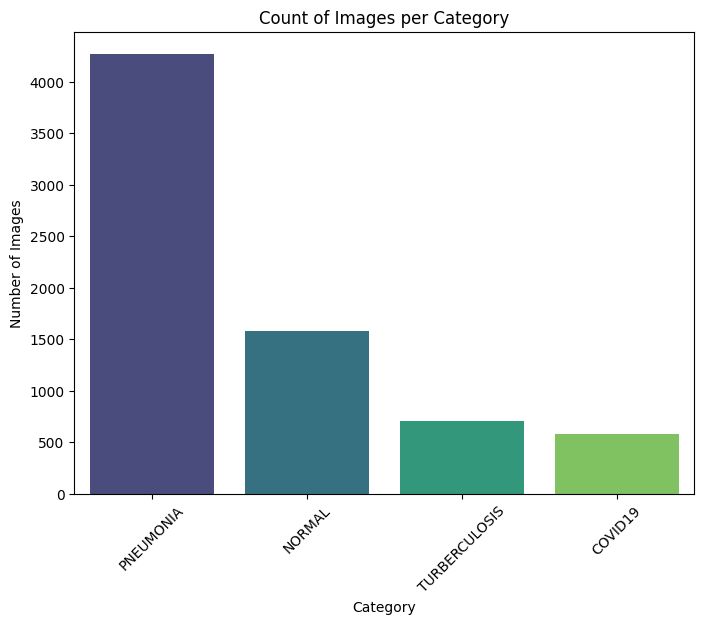

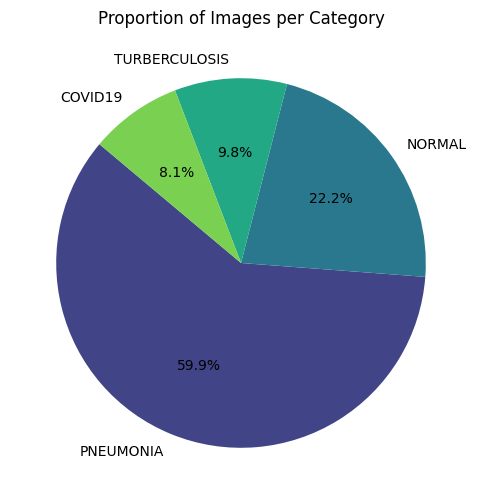

In [19]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the category counts using Spark
category_counts = df.groupBy("category").count().orderBy("count", ascending=False)

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
category_counts_pandas = category_counts.toPandas()

# Plotting the results using matplotlib and seaborn

# Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='category', y='count', data=category_counts_pandas, palette="viridis")
plt.title("Count of Images per Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts_pandas['count'], labels=category_counts_pandas['category'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts_pandas)))
plt.title("Proportion of Images per Category")
plt.show()


Form the graphical representation of the dataset, we can tell Pneumonia has more images in than all other classification categories. **59.9%** of the images are in the Pneunomia category, **22.2%** Normal, **9.8%** Turberculosis and **8.1%** COVID-19. This uneven distribution of the dataset might affect the classification traning of the model, therefore, we will be applying data augmentation to replicate some of the images in the other categories to achieve an almost equal distribution of the data.

Let's view some images from each category:

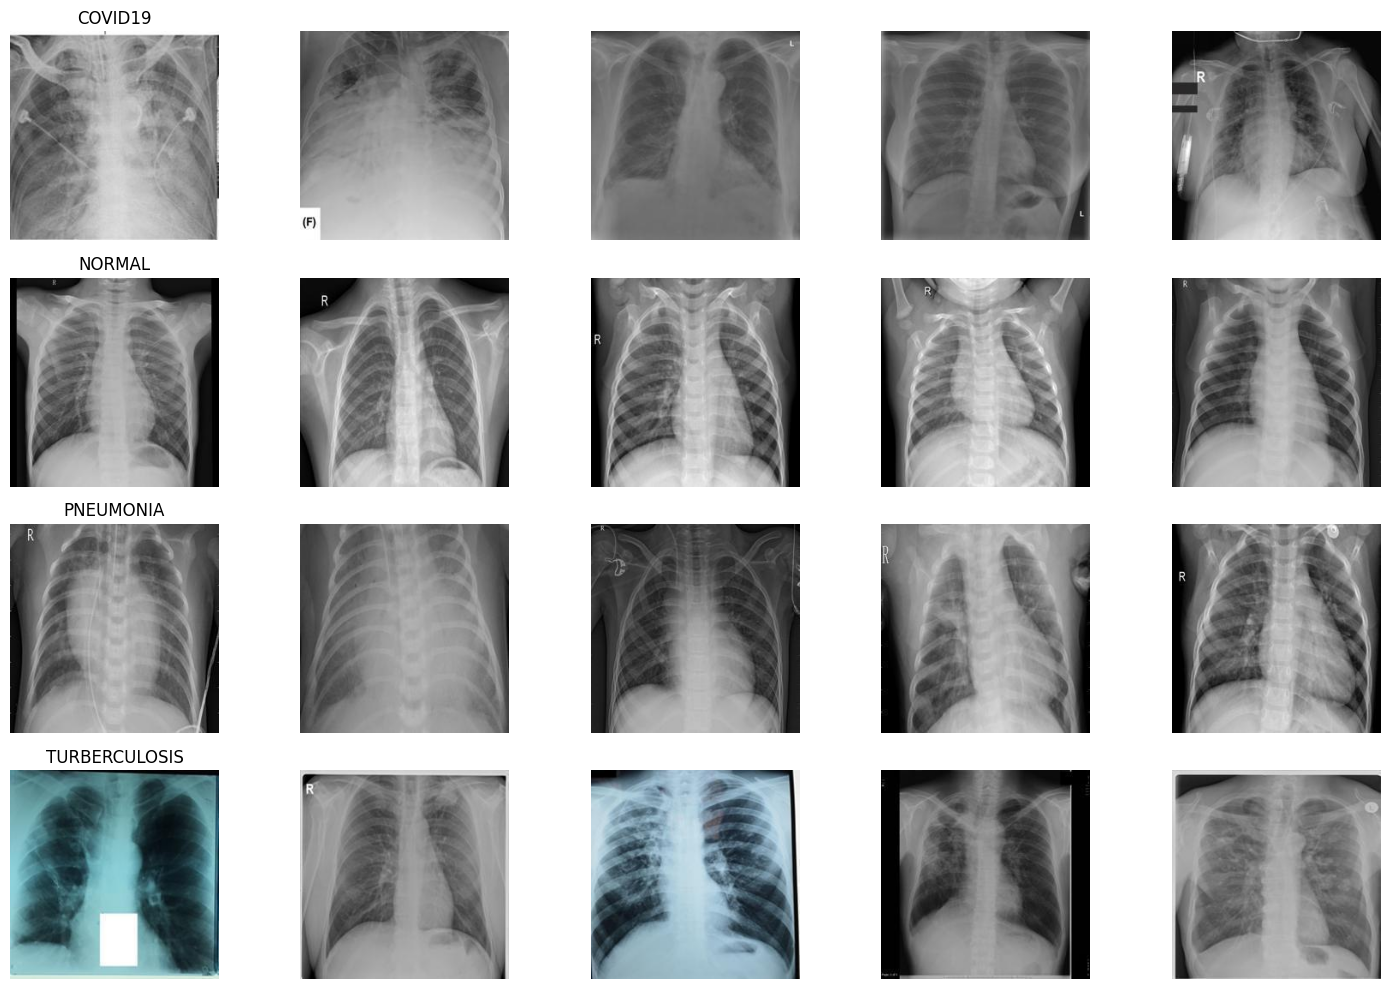

In [22]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from pyspark.sql import functions as F

# Define number of images per category
num_images_per_category = 5

# Get unique categories
categories = [row['category'] for row in df.select("category").distinct().collect()]

# Set up the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through categories to display images
for i, category in enumerate(categories):
    #  Select image paths for the current category
    category_images = df.filter(df['category'] == category).select('image_path').rdd.flatMap(lambda x: x).collect()
    
    # Randomly select images
    selected_images = random.sample(category_images, num_images_per_category)
    
    for j, image_path in enumerate(selected_images):
        # Open and display the image
        img = Image.open(image_path)
        
        # Create a subplot for each image
        plt.subplot(len(categories), num_images_per_category, i * num_images_per_category + j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category if j == 0 else "") 

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Preparing the Dataset for Training

### Encoding the Data Categories for training
To ensure learning, the category variable of the dataset is encoded for numerical representation using feature extraction to transform categorical data into numrical data for better model training.

In [13]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer for encoding the 'category' column
indexer = StringIndexer(inputCol="category", outputCol="category_encoded")

# Fit and transform the DataFrame
df = indexer.fit(df).transform(df)

# Show the result with the new 'category_encoded' column
df.show()


+--------------------+--------+----------------+
|          image_path|category|category_encoded|
+--------------------+--------+----------------+
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas...| COVID19|             3.0|
|Chest X_Ray Datas..

In [15]:
df.select("category", "category_encoded").distinct().show()

+-------------+----------------+
|     category|category_encoded|
+-------------+----------------+
|      COVID19|             3.0|
|       NORMAL|             1.0|
|    PNEUMONIA|             0.0|
|TURBERCULOSIS|             2.0|
+-------------+----------------+



## Refine Dataframe

In [17]:
df = df[['image_path', 'category_encoded']]
df.show()

+--------------------+----------------+
|          image_path|category_encoded|
+--------------------+----------------+
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
+--------------------+----------------+
only showing top 20 rows



## Data Augmentation
Duplicate the underrepresented classes by sampling with replacement in other to achieve an almost equal distribution of the data categories.

In [19]:
from pyspark.sql import functions as F

# Count the occurrences of each category in the dataset
category_counts = df.groupBy('category_encoded').count()

# Find the maximum count of any category
max_count = category_counts.agg(F.max("count")).collect()[0][0]

# Create a new DataFrame with oversampled data
resampled_df = df

# Perform oversampling for each category to match the max count
for row in category_counts.collect():
    category = row['category_encoded']
    count = row['count']
    
    # Calculate how many times to duplicate the rows for this category
    if count < max_count:
        num_duplicates = max_count - count
        
        # Calculate the fraction to use for sampling
        fraction = num_duplicates / count
        
        # Filter the original DataFrame to get the rows for this category
        category_df = df.filter(df['category_encoded'] == category)
        
        # Randomly sample with replacement from the category DataFrame to make up for the underrepresentation
        resampled_category_df = category_df.sample(withReplacement=True, fraction=fraction)
        
        # Union the oversampled category data with the original DataFrame
        resampled_df = resampled_df.union(resampled_category_df)

# Show the new class distribution after oversampling
resampled_df.groupBy('category_encoded').count().show()


+----------------+-----+
|category_encoded|count|
+----------------+-----+
|             3.0| 4225|
|             1.0| 4296|
|             0.0| 4273|
|             2.0| 4211|
+----------------+-----+



In [21]:
resampled_df.show()

+--------------------+----------------+
|          image_path|category_encoded|
+--------------------+----------------+
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
+--------------------+----------------+
only showing top 20 rows



In [23]:
import time
import shutil
import pathlib
import itertools
# For image processing and manipulation
import cv2

# For machine learning (not distributed, will work with PySpark data handling)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow & Keras for deep learning (Run outside of Spark if needed for model training)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Warning settings (for clean output)
import warnings
warnings.filterwarnings("ignore")

# Example check message
print('check')

check


In [25]:
from pyspark.sql.functions import col
resampled_df = resampled_df.withColumn("category_encoded", col("category_encoded").cast("string"))

In [27]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def union_all(dfs):
    """Utility function to union multiple DataFrames."""
    if not dfs:
        return None
    result = dfs[0]
    for df in dfs[1:]:
        result = result.union(df)
    return result

def stratified_split_balanced(df, stratify_col, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1, seed=42):
    categories = df.select(stratify_col).distinct().collect()
    train_dfs, valid_dfs, test_dfs = [], [], []
    
    for category in categories:
        category_value = category[stratify_col]
        category_df = df.filter(col(stratify_col) == category_value)
        
        train_df, valid_df, test_df = category_df.randomSplit([train_ratio, valid_ratio, test_ratio], seed=42)
        
        train_dfs.append(train_df)
        valid_dfs.append(valid_df)
        test_dfs.append(test_df)
    
    # Combine all splits
    train_df = union_all(train_dfs) if train_dfs else df.limit(0)
    valid_df = union_all(valid_dfs) if valid_dfs else df.limit(0)
    test_df = union_all(test_dfs) if test_dfs else df.limit(0)
    
    return train_df, valid_df, test_df

# Apply the stratified split
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

train_df_new, valid_df_new, test_df_new = stratified_split_balanced(resampled_df, "category_encoded", train_ratio, valid_ratio, test_ratio)

# Show the counts for verification
print("Train Set Count:", train_df_new.count())
print("Validation Set Count:", valid_df_new.count())
print("Test Set Count:", test_df_new.count())

# Optionally, verify the distribution
train_df_new.groupBy("category_encoded").count().show()
valid_df_new.groupBy("category_encoded").count().show()
test_df_new.groupBy("category_encoded").count().show()


Train Set Count: 13647
Validation Set Count: 1711
Test Set Count: 1647
+----------------+-----+
|category_encoded|count|
+----------------+-----+
|             3.0| 3411|
|             1.0| 3435|
|             0.0| 3414|
|             2.0| 3387|
+----------------+-----+

+----------------+-----+
|category_encoded|count|
+----------------+-----+
|             3.0|  415|
|             1.0|  422|
|             0.0|  433|
|             2.0|  441|
+----------------+-----+

+----------------+-----+
|category_encoded|count|
+----------------+-----+
|             3.0|  399|
|             1.0|  439|
|             0.0|  426|
|             2.0|  383|
+----------------+-----+



In [34]:
train_df_new.show()
valid_df_new.show()
test_df_new.show()

+--------------------+----------------+
|          image_path|category_encoded|
+--------------------+----------------+
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
|Chest X_Ray Datas...|             3.0|
+--------------------+----------------+
only showing top 20 rows

+-------------

## Image Preparation

All our selected models have a default image size requirement of **255 * 255** to enable smooth learning. Image preparation arguments include the following:

- include_top
- weights
- input_tensor
- input_shape
- pooling
- classes
- classifier_activation
- name (string).

In [ ]:
from PIL import Image
import os

# Function to convert and resize an image
def convert_and_resize_image(image_path, target_size=(255, 255)):
    try:
        # Check if the file exists
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            return

        # Open the image
        img = Image.open(image_path)

        # Convert to RGB if needed (e.g., for PNG or other formats)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image
        img_resized = img.resize(target_size)

        # Ensure the file is saved as JPG
        new_path = os.path.splitext(image_path)[0] + ".jpg"
        img_resized.save(new_path, "JPEG")

        # Remove the original file if it’s not already JPG
        if not image_path.lower().endswith('.jpg'):
            os.remove(image_path)

        print(f"Processed: {image_path} -> {new_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Function to process all images in a directory (including subdirectories)
def process_images_in_directory(source_dir, target_size=(244, 244)):
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Supported formats
                image_path = os.path.join(root, file)
                convert_and_resize_image(image_path, target_size)

# Set the source directory
source_dir = "Chest X_Ray Dataset"  # Replace with your source directory path

# Process all images in the directory and subdirectories
process_images_in_directory(source_dir)

print("Image processing complete.")


In [ ]:
from PIL import Image
import os

# Function to check image size
def check_image_size(image_path, target_size=(255, 255)):
    try:
        # Open the image
        img = Image.open(image_path)

        # Get image dimensions
        if img.size == target_size:
            return f"Valid: {image_path}"
        else:
            return f"Invalid: {image_path} - Size: {img.size}"
    except Exception as e:
        return f"Error processing {image_path}: {e}"

# Function to validate all images in the directory
def validate_image_sizes(source_dir, target_size=(244, 244)):
    invalid_images = []
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Supported formats
                image_path = os.path.join(root, file)
                result = check_image_size(image_path, target_size)
                print(result)
                if "Invalid" in result or "Error" in result:
                    invalid_images.append(result)
    return invalid_images

# Set the source directory
source_dir = "Chest X_Ray Dataset"  # Replace with your source directory path

# Check all images and collect results
invalid_images = validate_image_sizes(source_dir)

# Print summary
if invalid_images:
    print("\nInvalid images detected:")
    for invalid in invalid_images:
        print(invalid)
else:
    print("\nAll images are valid and sized correctly!")


## Training the VGG19 Model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [40]:
# Convert Spark DataFrame to Pandas DataFrame
train_pd_df = train_df_new.toPandas()
valid_pd_df = valid_df_new.toPandas()

# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [41]:
# Define the model architecture
def create_vgg19_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = VGG19(weights='imagenet', input_tensor=inputs, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    height, width, channels = 7, 7, 512
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224, 224, 3)

In [ ]:
# Initialize data generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_pd_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_pd_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

VGG19_model = create_vgg19_model(input_shape)

VGG19_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [
    early_stopping, 
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True)
]

history = VGG19_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
from pyspark.sql.types import StructType, StructField, FloatType
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history.history
history_data = {
    "epoch": list(range(1, len(history.history['accuracy']) + 1)),
    "train_accuracy": [float(acc) for acc in history.history['accuracy']],
    "val_accuracy": [float(acc) for acc in history.history['val_accuracy']]
}

# Convert to Spark DataFrame
schema = StructType([
    StructField("epoch", FloatType(), True),
    StructField("train_accuracy", FloatType(), True),
    StructField("val_accuracy", FloatType(), True)
])

# Ensure data is in tuple format and matches schema
data = [
    (float(epoch), float(train), float(val)) 
    for epoch, train, val in zip(history_data["epoch"], history_data["train_accuracy"], history_data["val_accuracy"])
]
history_df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame (optional for inspection)
history_df.show()

# Collect data back to Pandas or lists for plotting
history_pd = history_df.toPandas()

# Plot the data using Matplotlib
plt.plot(history_pd['epoch'], history_pd['train_accuracy'], label='Train Accuracy')
plt.plot(history_pd['epoch'], history_pd['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


## Predict the testing data

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Convert Spark DataFrame to Pandas DataFrame
test_pd_dfVGG = test_df_new.toPandas()

# Define the function to preprocess and predict a single image
def predict_image(image_path, model, target_size=(224, 224)):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the class probabilities
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
        return predicted_class
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Predict classes for all images in the test DataFrame
test_pd_dfVGG['predicted_class'] = test_pd_dfVGG['image_path'].apply(lambda x: predict_image(x, VGG19_model))

# Drop rows with prediction errors (if any)
test_pd_dfVGG = test_pd_dfVGG.dropna(subset=['predicted_class'])

# Display the first few predictions
print(test_pd_dfVGG[['image_path', 'predicted_class']].head())


Unique values after conversion: [3 1 0 2]


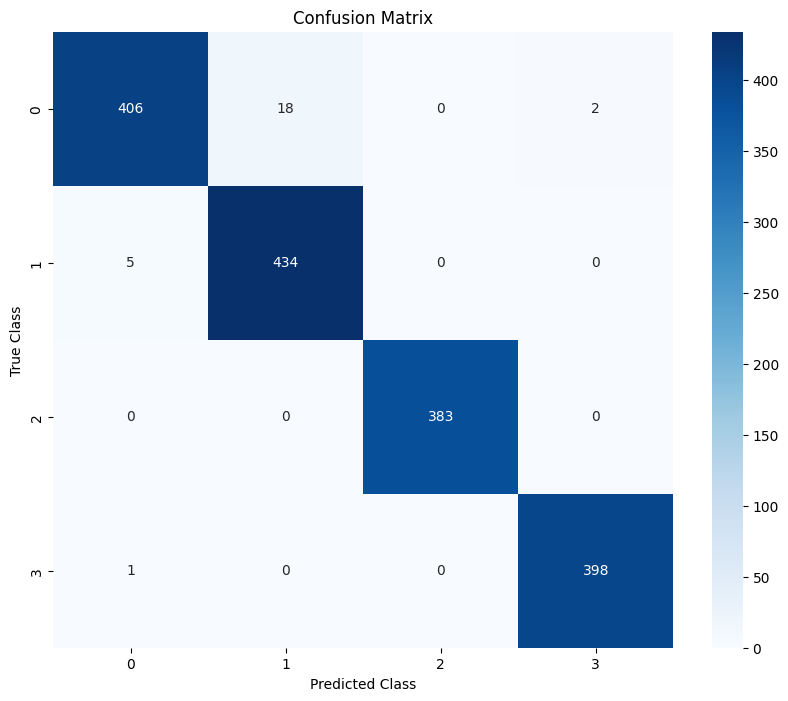

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert category_encoded from object to int64
test_pd_dfVGG['category_encoded'] = test_pd_dfVGG['category_encoded'].astype(float).astype(int)

# Verify the conversion
print("Unique values after conversion:", test_pd_dfVGG['category_encoded'].unique())

# Extract true labels and predicted labels
true_labels = test_pd_dfVGG['category_encoded']
predicted_labels = test_pd_dfVGG['predicted_class']

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [39]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(test_pd_dfVGG['category_encoded'], test_pd_dfVGG['predicted_class'])

# Print the accuracy
print(f"Overall Testing Prediction Accuracy: {accuracy * 100:.2f}%")

Overall Testing Prediction Accuracy: 98.42%


In [41]:
# Precision, Recall, F1-Score

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_pd_dfVGG['category_encoded'], test_pd_dfVGG['predicted_class'], target_names=['0', '1', '2', '3'])
print(report)


              precision    recall  f1-score   support

           0       0.99      0.95      0.97       426
           1       0.96      0.99      0.97       439
           2       1.00      1.00      1.00       383
           3       0.99      1.00      1.00       399

    accuracy                           0.98      1647
   macro avg       0.99      0.98      0.98      1647
weighted avg       0.98      0.98      0.98      1647



In [43]:
# MSE and R_Square
from sklearn.metrics import mean_squared_error, r2_score

true_values = test_pd_dfVGG['category_encoded']  # Replace with actual column
predicted_values = test_pd_dfVGG['predicted_class']

# Compute metrics
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 0.03
R-Squared (R²): 0.98


In [50]:
from pyspark.ml.pipeline import PipelineModel

VGG19_model.save('VGG19.model.keras')

#loaded_model = PipelineModel.load("path/to/save/model")

In [ ]:
### loaded_model ###

#from tensorflow.keras.models import load_model

# Load the Keras model
#VGG19_model = load_model('VGG19.model.keras')

# Verify the model summary
#VGG19_model.summary()

Category: 3.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


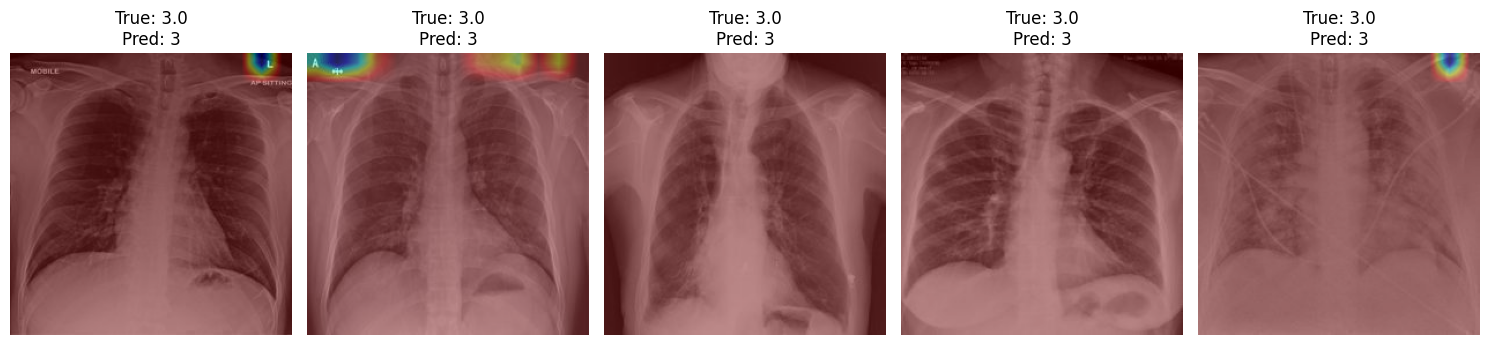

Category: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


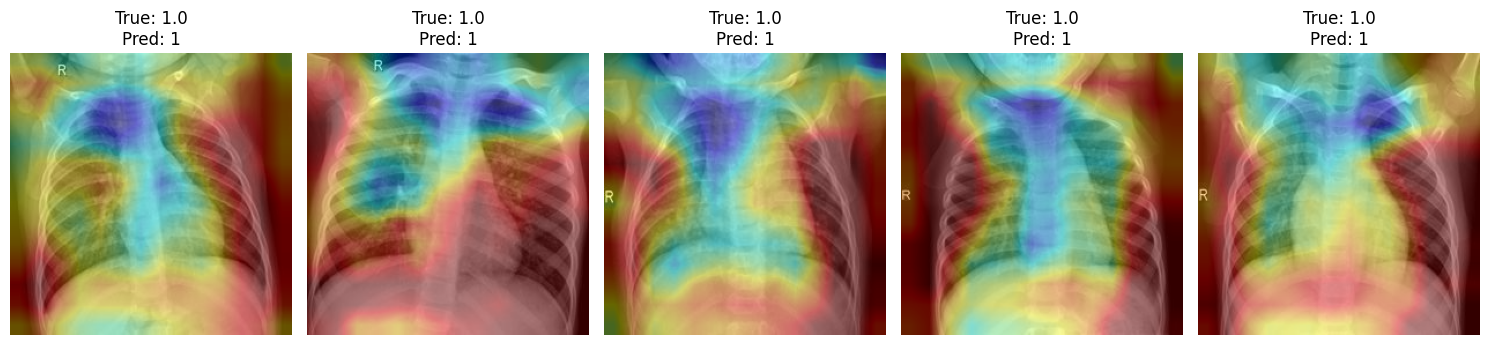

Category: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


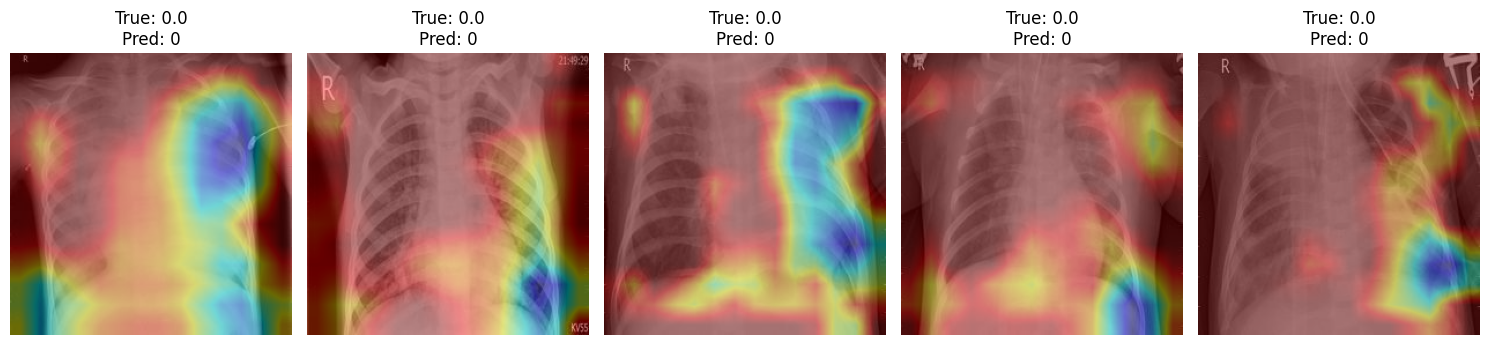

Category: 2.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


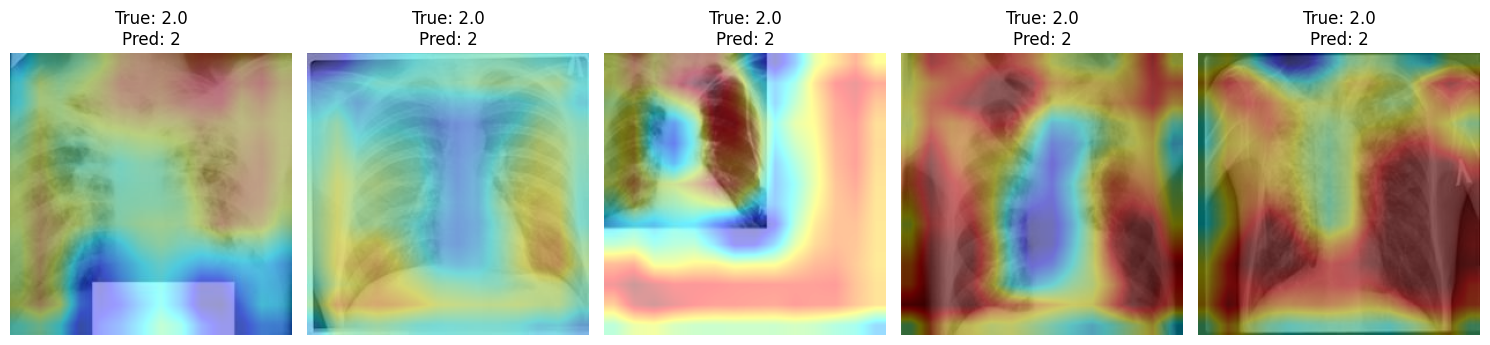

In [45]:
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, image_array, target_layer, class_index):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(target_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize heatmap
    return heatmap.numpy()

# Overlay Grad-CAM heatmap on the original image
def overlay_heatmap(heatmap, image_path, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, colormap)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# Get 5 random images per category and predict
def predict_and_visualize(df, model, target_layer, categories_col='category_encoded', image_path_col='image_path', n_images=5):
    categories = df[categories_col].unique()
    for category in categories:
        category_images = df[df[categories_col] == category][image_path_col].sample(n_images, random_state=42)
        
        print(f"Category: {category}")
        plt.figure(figsize=(15, 10))
        
        for i, image_path in enumerate(category_images):
            preprocessed_img = preprocess_image(image_path)
            predicted_class = np.argmax(model.predict(preprocessed_img))
            
            # Generate Grad-CAM heatmap
            heatmap = generate_gradcam_heatmap(model, preprocessed_img, target_layer, predicted_class)
            
            # Overlay heatmap on the original image
            overlay_image = overlay_heatmap(heatmap, image_path)
            
            # Display the image
            plt.subplot(1, n_images, i + 1)
            plt.imshow(overlay_image)
            plt.axis('off')
            plt.title(f"True: {category}\nPred: {predicted_class}")
        
        plt.tight_layout()
        plt.show()

# Apply function to visualize
predict_and_visualize(
    df=test_df_new.toPandas(),  # Convert Spark DataFrame to Pandas
    model=VGG19_model,
    target_layer='block5_conv4',  # Adjust based on your VGG19_model's architecture
    categories_col='category_encoded',
    image_path_col='image_path',
    n_images=5
)

## Tracking Using Pandas  UDF

In [234]:
def process_images_udf(batch_df: pd.DataFrame) -> pd.DataFrame:
    results = []
    for _, row in batch_df.iterrows():
        try:
            image_path = row['image_path']
            true_label = row['category_encoded']
            
            # Preprocess image
            preprocessed_img = preprocess_image(image_path)
            
            # Predict
            predictions = VGG19_model.predict(preprocessed_img)
            predicted_class = int(np.argmax(predictions))
            confidence = float(predictions[0, predicted_class])
            
            # Generate Grad-CAM
            heatmap = generate_gradcam_heatmap(
                VGG19_model, 
                preprocessed_img, 
                target_layer="block5_conv4", 
                class_index=predicted_class
            )
            overlay_image = overlay_heatmap(heatmap, image_path)
            
            # Save overlay
            overlay_path = f"gradcam/VGG19/{os.path.basename(image_path).replace('.jpg', '_gradcam.jpg')}"
            cv2.imwrite(overlay_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
            
            # Append results
            results.append({
                "image_path": image_path,
                "true_label": true_label,
                "predicted_class": predicted_class,
                "confidence": confidence,
                "gradcam_overlay_path": overlay_path
            })
        except Exception as e:
            print(f"Error processing image {row['image_path']}: {e}")
            results.append({
                "image_path": row['image_path'],
                "true_label": row['category_encoded'],
                "predicted_class": -1,  # Placeholder for errors
                "confidence": 0.0,
                "gradcam_overlay_path": "error"
            })
    return pd.DataFrame(results)


In [ ]:
output_dfVGG = process_images_udf(test_pd_dfVGG) 

In [252]:
# Save the DataFrame to a CSV file
output_dfVGG = spark.createDataFrame(output_dfVGG)
output_dfVGG.write.csv("gradcam/VGG19/CSV/", header=True, mode="overwrite")

# Print the DataFrame to the console
output_dfVGG.show(truncate=False)


+--------------------------------------------+----------+---------------+------------------+--------------------------------------+
|image_path                                  |true_label|predicted_class|confidence        |gradcam_overlay_path                  |
+--------------------------------------------+----------+---------------+------------------+--------------------------------------+
|Chest X_Ray Dataset\COVID19\COVID19(103).jpg|3         |3              |0.9962544441223145|gradcam/VGG19/COVID19(103)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(105).jpg|3         |3              |0.9501827955245972|gradcam/VGG19/COVID19(105)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(140).jpg|3         |3              |0.9852234125137329|gradcam/VGG19/COVID19(140)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(148).jpg|3         |3              |0.9998782873153687|gradcam/VGG19/COVID19(148)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(168).jpg|3         |3              |0.9

52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


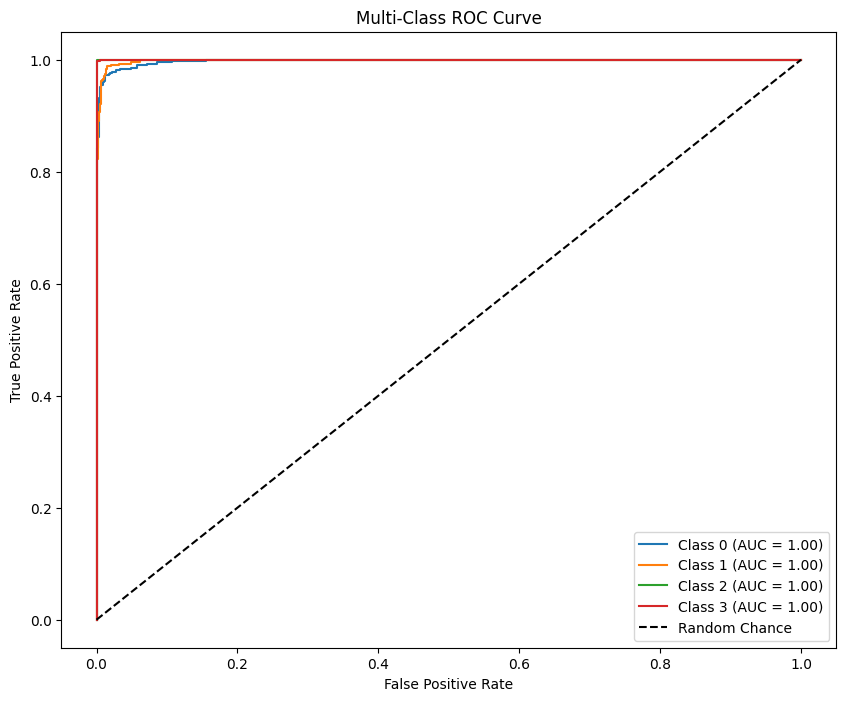

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Preprocess all test images
test_image_paths = test_pd_dfVGG['image_path'].tolist()
test_images = np.array([preprocess_image(path) for path in test_image_paths])  # Preprocess all images
test_images = np.vstack(test_images)  # Stack into a batch

# Get true labels
true_labels = test_pd_dfVGG['category_encoded'].to_numpy()

# Predict probabilities for all classes
predicted_probabilities = VGG19_model.predict(test_images)  # Shape: (n_samples, n_classes)

# Number of categories
n_classes = predicted_probabilities.shape[1]

# Binarize the true labels for multi-class ROC
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(n_classes))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Configure the plot
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Training the ResNet101 Model

In [49]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Reshape, MultiHeadAttention, GaussianNoise, 
    GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
)
# Convert Spark DataFrame to Pandas DataFrame
train_pd_df = train_df_new.toPandas()
valid_pd_df = valid_df_new.toPandas()

In [56]:
from tensorflow.keras.applications import ResNet101

def create_resnet101_model(input_shape):
    # Define the input
    inputs = Input(shape=input_shape)
    
    # Load the ResNet101 base model
    base_model = ResNet101(weights='imagenet', input_tensor=inputs, include_top=False)
    
    # Freeze the base model layers to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    height, width, channels = 7, 7, 2048  # ResNet101 has 2048 feature maps in the final convolutional block
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)
    return model
input_shape = (224, 224, 3)

In [ ]:
# Initialize data generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_pd_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_pd_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

# Instantiate the ResNet101 model
resnet101_model = create_resnet101_model(input_shape)

# Compile the model
resnet101_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [
    early_stopping, 
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True)
]

# Train the model with the same data generators and callbacks
history_resnet101 = resnet101_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
from pyspark.sql.types import StructType, StructField, FloatType
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history_resnet101.history
history_resnet_data = {
    "epoch": list(range(1, len(history_resnet101.history['accuracy']) + 1)),
    "train_accuracy": [float(acc) for acc in history_resnet101.history['accuracy']],
    "val_accuracy": [float(acc) for acc in history_resnet101.history['val_accuracy']]
}

# Define schema for Spark DataFrame
schema = StructType([
    StructField("epoch", FloatType(), True),
    StructField("train_accuracy", FloatType(), True),
    StructField("val_accuracy", FloatType(), True)
])

# Prepare data in tuple format
data_resnet = [
    (float(epoch), float(train), float(val)) 
    for epoch, train, val in zip(history_resnet_data["epoch"], 
                                 history_resnet_data["train_accuracy"], 
                                 history_resnet_data["val_accuracy"])
]

# Create Spark DataFrame for ResNet history
history_resnet_df = spark.createDataFrame(data_resnet, schema=schema)

# Show the DataFrame (optional for inspection)
history_resnet_df.show()

# Convert to Pandas DataFrame for plotting
history_resnet_pd = history_resnet_df.toPandas()

# Plot training and validation accuracy for ResNet model
plt.figure(figsize=(10, 6))
plt.plot(history_resnet_pd['epoch'], history_resnet_pd['train_accuracy'], label='Train Accuracy')
plt.plot(history_resnet_pd['epoch'], history_resnet_pd['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Convert Spark DataFrame to Pandas DataFrame
test_pd_dfRes = test_df_new.toPandas()

# Define the function to preprocess and predict a single image
def predict_image(image_path, model, target_size=(224, 224)):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the class probabilities
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
        return predicted_class
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Predict classes for all images in the test DataFrame
test_pd_dfRes['predicted_class'] = test_pd_dfRes['image_path'].apply(lambda x: predict_image(x, resnet101_model))

# Drop rows with prediction errors (if any)
test_pd_dfRes = test_pd_dfRes.dropna(subset=['predicted_class'])

# Display the first few predictions
print(test_pd_dfRes[['image_path', 'predicted_class']].head())


Unique values after conversion: [3 1 0 2]


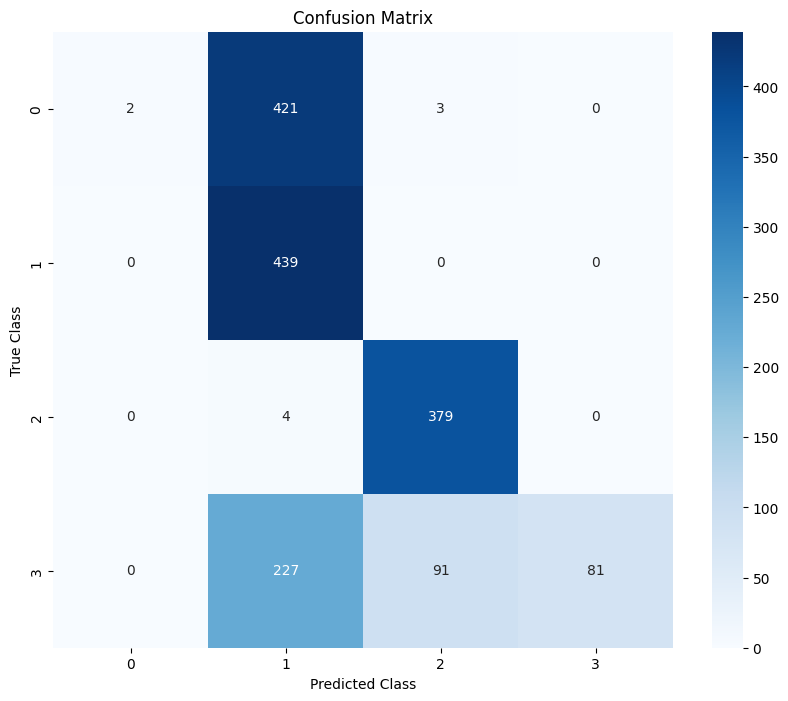

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert category_encoded from object to int64
test_pd_dfRes['category_encoded'] = test_pd_dfRes['category_encoded'].astype(float).astype(int)

# Verify the conversion
print("Unique values after conversion:", test_pd_dfRes['category_encoded'].unique())

# Extract true labels and predicted labels
true_labels = test_pd_dfRes['category_encoded']
predicted_labels = test_pd_dfRes['predicted_class']

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [59]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(test_pd_dfRes['category_encoded'], test_pd_dfRes['predicted_class'])

# Print the accuracy
print(f"Overall Testing Prediction Accuracy: {accuracy * 100:.2f}%")

Overall Testing Prediction Accuracy: 54.71%


In [61]:
# Precision, Recall, F1-Score

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_pd_dfRes['category_encoded'], test_pd_dfRes['predicted_class'], target_names=['0', '1', '2', '3'])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       426
           1       0.40      1.00      0.57       439
           2       0.80      0.99      0.89       383
           3       1.00      0.20      0.34       399

    accuracy                           0.55      1647
   macro avg       0.80      0.55      0.45      1647
weighted avg       0.79      0.55      0.44      1647



In [63]:
from sklearn.metrics import mean_squared_error, r2_score

true_values = test_pd_dfRes['category_encoded']  # Replace with actual column
predicted_values = test_pd_dfRes['predicted_class']

# Compute metrics
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 0.87
R-Squared (R²): 0.30


In [ ]:
from pyspark.ml.pipeline import PipelineModel

resnet101_model.save('ResNet101.model.keras')

#loaded_model = PipelineModel.load("path/to/save/model")

In [ ]:
### loaded_model ###

#from tensorflow.keras.models import load_model

# Load the Keras model
#resnet101_model = load_model('resnet101.model.keras')

# Verify the model summary
#resnet101_model.summary()

Category: 3.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


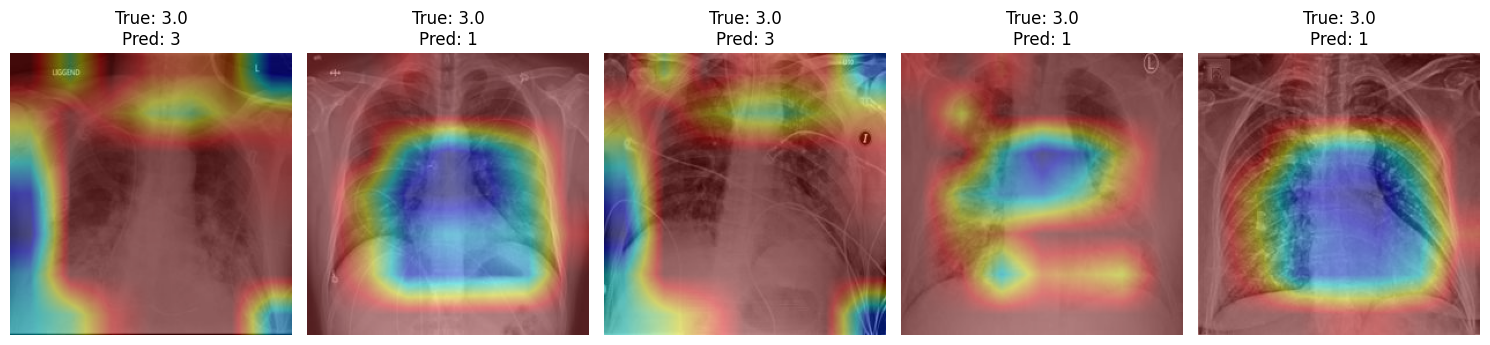

Category: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


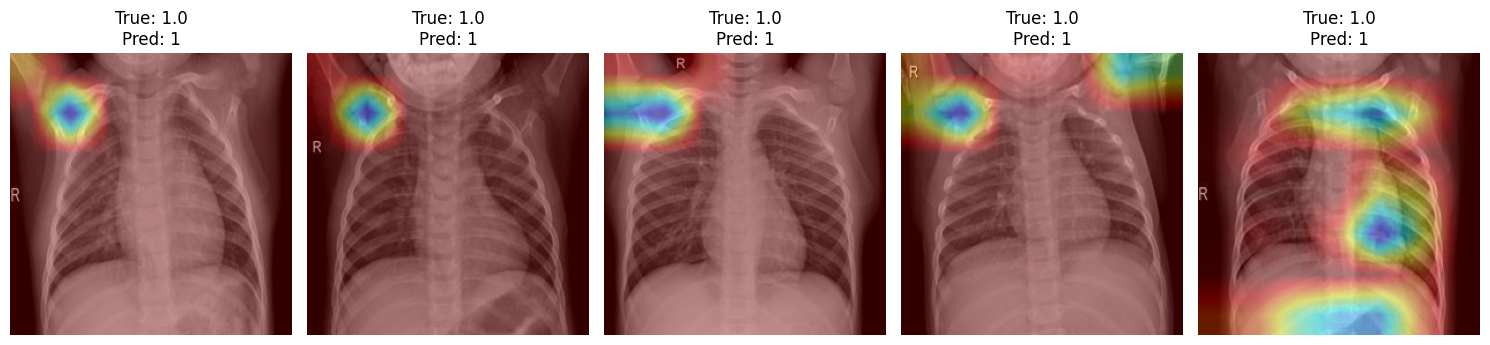

Category: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


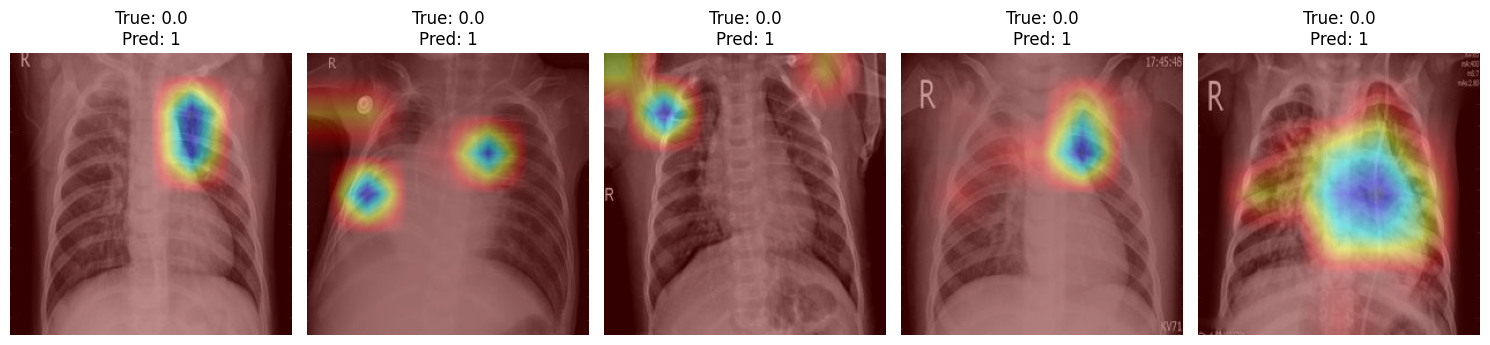

Category: 2.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


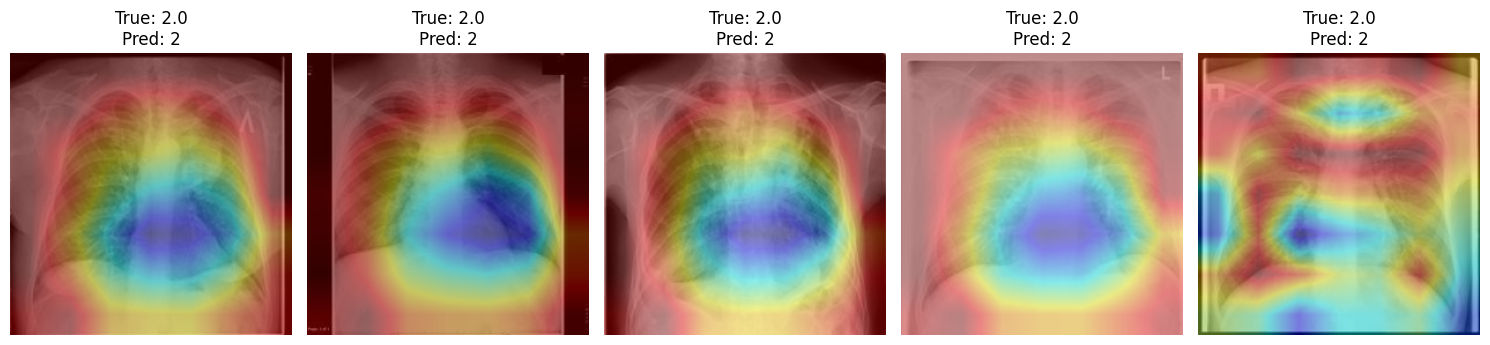

In [65]:
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, image_array, target_layer, class_index):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(target_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize heatmap
    return heatmap.numpy()

# Overlay Grad-CAM heatmap on the original image
def overlay_heatmap(heatmap, image_path, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, colormap)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# Get 5 random images per category and predict
def predict_and_visualize(df, model, target_layer, categories_col='category_encoded', image_path_col='image_path', n_images=5):
    categories = df[categories_col].unique()
    for category in categories:
        category_images = df[df[categories_col] == category][image_path_col].sample(n_images, random_state=42, replace=True)
        
        print(f"Category: {category}")
        plt.figure(figsize=(15, 10))
        
        for i, image_path in enumerate(category_images):
            try:
                preprocessed_img = preprocess_image(image_path)
                predicted_class = np.argmax(model.predict(preprocessed_img))
                
                # Generate Grad-CAM heatmap
                heatmap = generate_gradcam_heatmap(model, preprocessed_img, target_layer, predicted_class)
                
                # Overlay heatmap on the original image
                overlay_image = overlay_heatmap(heatmap, image_path)
                
                # Display the image
                plt.subplot(1, n_images, i + 1)
                plt.imshow(overlay_image)
                plt.axis('off')
                plt.title(f"True: {category}\nPred: {predicted_class}")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
        
        plt.tight_layout()
        plt.show()

# Apply function to visualize
predict_and_visualize(
    df=test_df_new.toPandas(),  # Convert Spark DataFrame to Pandas
    model=resnet101_model,
    target_layer='conv5_block3_out',  # Example target layer for ResNet101
    categories_col='category_encoded',
    image_path_col='image_path',
    n_images=5
)


## Tracking using Pandas UDF

In [ ]:
def process_images_udf(batch_df: pd.DataFrame) -> pd.DataFrame:
    results = []
    for _, row in batch_df.iterrows():
        try:
            image_path = row['image_path']
            true_label = row['category_encoded']
            
            # Preprocess image
            preprocessed_img = preprocess_image(image_path)
            
            # Predict
            predictions = resnet101_model.predict(preprocessed_img)
            predicted_class = int(np.argmax(predictions))
            confidence = float(predictions[0, predicted_class])
            
            # Generate Grad-CAM
            heatmap = generate_gradcam_heatmap(
                resnet101_model, 
                preprocessed_img, 
                target_layer="conv5_block3_out", 
                class_index=predicted_class
            )
            overlay_image = overlay_heatmap(heatmap, image_path)
            
            # Save overlay
            overlay_path = f"gradcam/ResNet101/{os.path.basename(image_path).replace('.jpg', '_gradcam.jpg')}"
            cv2.imwrite(overlay_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
            
            # Append results
            results.append({
                "image_path": image_path,
                "true_label": true_label,
                "predicted_class": predicted_class,
                "confidence": confidence,
                "gradcam_overlay_path": overlay_path
            })
        except Exception as e:
            print(f"Error processing image {row['image_path']}: {e}")
            results.append({
                "image_path": row['image_path'],
                "true_label": row['category_encoded'],
                "predicted_class": -1,  # Placeholder for errors
                "confidence": 0.0,
                "gradcam_overlay_path": "error"
            })
    return pd.DataFrame(results)

output_dfRES = process_images_udf(test_pd_dfRes) 

In [266]:
# Save the DataFrame to a CSV file
output_dfRES = spark.createDataFrame(output_dfRES)
output_dfRES.write.csv("gradcam/ResNet101/CSV/", header=True, mode="overwrite")

# Print the DataFrame to the console
output_dfRES.show(truncate=False)


+--------------------------------------------+----------+---------------+------------------+------------------------------------------+
|image_path                                  |true_label|predicted_class|confidence        |gradcam_overlay_path                      |
+--------------------------------------------+----------+---------------+------------------+------------------------------------------+
|Chest X_Ray Dataset\COVID19\COVID19(103).jpg|3         |1              |0.8926270008087158|gradcam/ResNet101/COVID19(103)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(105).jpg|3         |2              |0.8466391563415527|gradcam/ResNet101/COVID19(105)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(140).jpg|3         |3              |0.85169517993927  |gradcam/ResNet101/COVID19(140)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(148).jpg|3         |1              |0.9759021401405334|gradcam/ResNet101/COVID19(148)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(168).jpg|3 

52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step


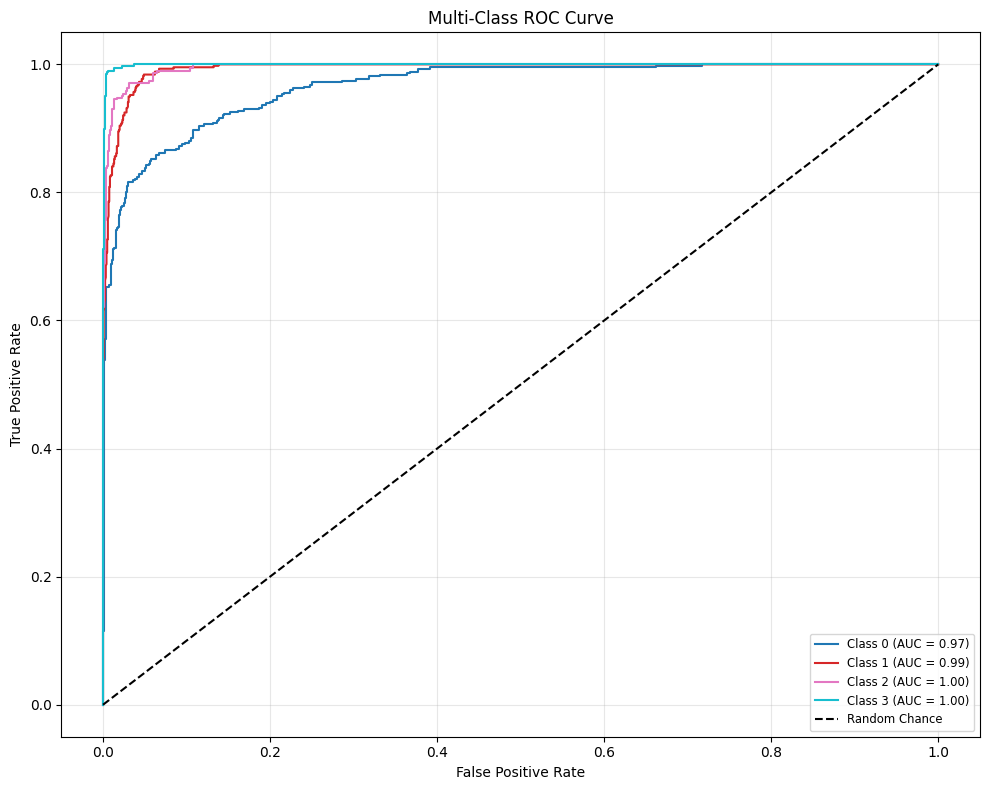

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Preprocess all test images
test_image_paths = test_pd_dfRes['image_path'].tolist()
test_images = np.array([preprocess_image(path) for path in test_image_paths])  # Preprocess all images
test_images = np.vstack(test_images)  # Stack into a batch

# Get true labels
true_labels = test_pd_dfRes['category_encoded'].to_numpy()

# Predict probabilities for all classes
predicted_probabilities = resnet101_model.predict(test_images)  # Shape: (n_samples, n_classes)

# Number of categories
n_classes = predicted_probabilities.shape[1]

# Binarize the true labels for multi-class ROC
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(n_classes))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)  # Use a colormap with distinct colors for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})', color=colors(i))

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Configure the plot
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Training EfficientNetB2

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
train_pd_dfEff = train_df_new.toPandas()
valid_pd_dfEff = valid_df_new.toPandas()

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

# Define model creation function
def create_efficientnetb2_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Base model: EfficientNetB2
    base_model = EfficientNetB2(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Input parameters
input_shape = (224, 224, 3)
num_classes = 4

In [ ]:
# Data preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_pd_dfEff,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_pd_dfEff,
    x_col='image_path',
    y_col='category_encoded',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse'
)

# Create the EfficientNetB2 model
efficientnetb2_model = create_efficientnetb2_model(input_shape, num_classes)

# Compile the model
efficientnetb2_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb2_best_model.keras', save_best_only=True)

# Train the model
history_efficient = efficientnetb2_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

In [ ]:
from pyspark.sql.types import StructType, StructField, FloatType
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history_resnet101.history
history_efficient_data = {
    "epoch": list(range(1, len(history_efficient.history['accuracy']) + 1)),
    "train_accuracy": [float(acc) for acc in history_efficient.history['accuracy']],
    "val_accuracy": [float(acc) for acc in history_efficient.history['val_accuracy']]
}

# Define schema for Spark DataFrame
schema = StructType([
    StructField("epoch", FloatType(), True),
    StructField("train_accuracy", FloatType(), True),
    StructField("val_accuracy", FloatType(), True)
])

# Prepare data in tuple format
data_efficient = [
    (float(epoch), float(train), float(val)) 
    for epoch, train, val in zip(history_efficient_data["epoch"], 
                                 history_efficient_data["train_accuracy"], 
                                 history_efficient_data["val_accuracy"])
]

# Create Spark DataFrame for ResNet history
history_efficient_df = spark.createDataFrame(data_efficient, schema=schema)

# Show the DataFrame (optional for inspection)
history_efficient_df.show()

# Convert to Pandas DataFrame for plotting
history_efficient_pd = history_efficient_df.toPandas()

# Plot training and validation accuracy for ResNet model
plt.figure(figsize=(10, 6))
plt.plot(history_efficient_pd['epoch'], history_efficient_pd['train_accuracy'], label='Train Accuracy')
plt.plot(history_efficient_pd['epoch'], history_efficient_pd['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Convert Spark DataFrame to Pandas DataFrame
test_pd_dfEff = test_df_new.toPandas()

# Define the function to preprocess and predict a single image
def predict_image(image_path, model, target_size=(224, 224)):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Predict the class probabilities
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
        return predicted_class
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Predict classes for all images in the test DataFrame
test_pd_dfEff['predicted_class'] = test_pd_dfEff['image_path'].apply(lambda x: predict_image(x, efficientnetb2_model))

# Drop rows with prediction errors (if any)
test_pd_dfEff = test_pd_dfRes.dropna(subset=['predicted_class'])

# Display the first few predictions
print(test_pd_dfEff[['image_path', 'predicted_class']].head())

Unique values after conversion: [3 1 0 2]


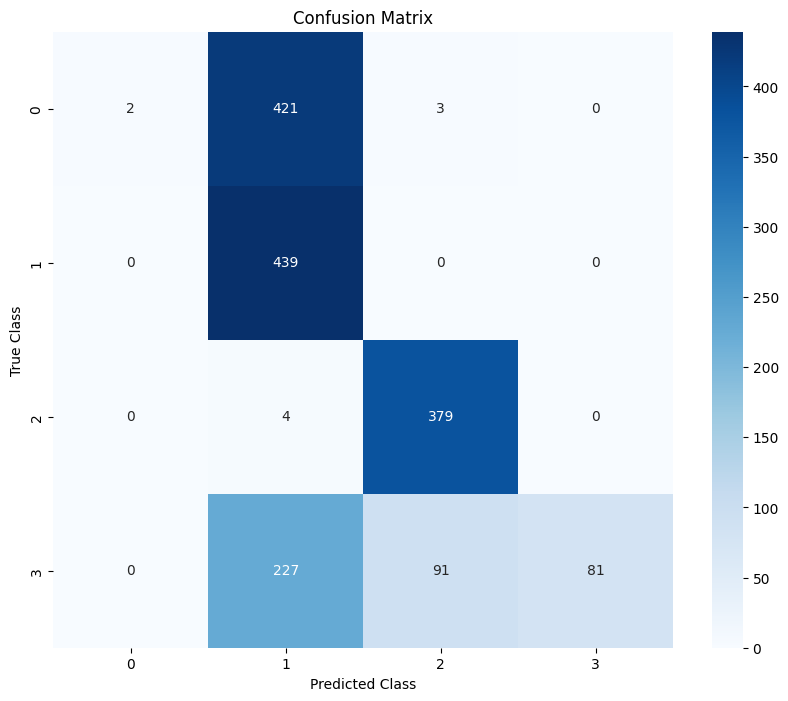

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert category_encoded from object to int64
test_pd_dfEff['category_encoded'] = test_pd_dfEff['category_encoded'].astype(float).astype(int)

# Verify the conversion
print("Unique values after conversion:", test_pd_dfEff['category_encoded'].unique())

# Extract true labels and predicted labels
true_labels = test_pd_dfEff['category_encoded']
predicted_labels = test_pd_dfEff['predicted_class']

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [81]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(test_pd_dfEff['category_encoded'], test_pd_dfEff['predicted_class'])

# Print the accuracy
print(f"Overall Testing Prediction Accuracy: {accuracy * 100:.2f}%")

Overall Testing Prediction Accuracy: 54.71%


In [83]:
# Precision, Recall, F1-Score

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_pd_dfEff['category_encoded'], test_pd_dfEff['predicted_class'], target_names=['0', '1', '2', '3'])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       426
           1       0.40      1.00      0.57       439
           2       0.80      0.99      0.89       383
           3       1.00      0.20      0.34       399

    accuracy                           0.55      1647
   macro avg       0.80      0.55      0.45      1647
weighted avg       0.79      0.55      0.44      1647



In [85]:
from sklearn.metrics import mean_squared_error, r2_score

true_values = test_pd_dfEff['category_encoded']  # Replace with actual column
predicted_values = test_pd_dfEff['predicted_class']

# Compute metrics
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 0.87
R-Squared (R²): 0.30


In [ ]:
from pyspark.ml.pipeline import PipelineModel

resnet101_model.save('efficientnetb2.model.keras')

#loaded_model = PipelineModel.load("path/to/save/model")

In [ ]:
### loaded_model ###

#from tensorflow.keras.models import load_model

# Load the Keras model
#efficientnetb2_model = load_model('efficientnetb2.model.keras')

# Verify the model summary
#efficientnetb2_model.summary()

Category: 3.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


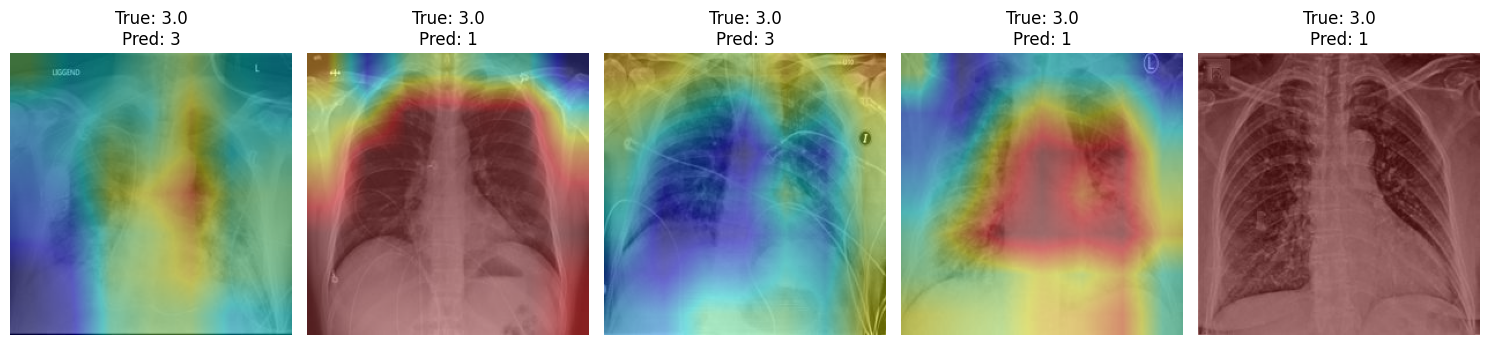

Category: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


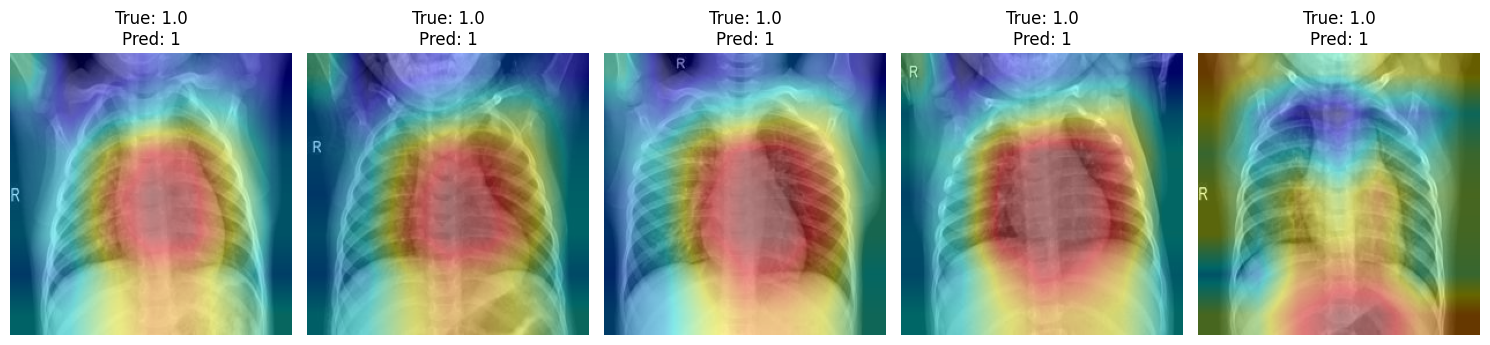

Category: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


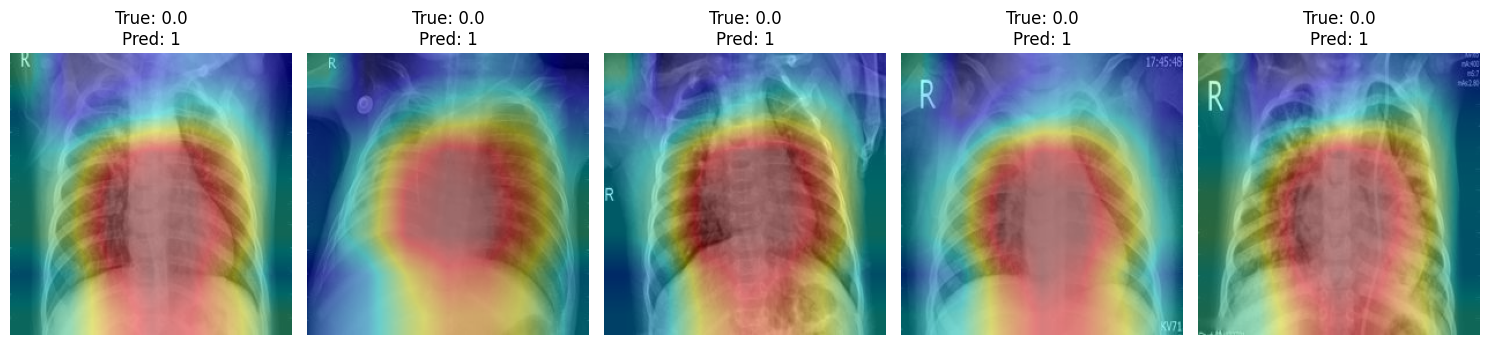

Category: 2.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


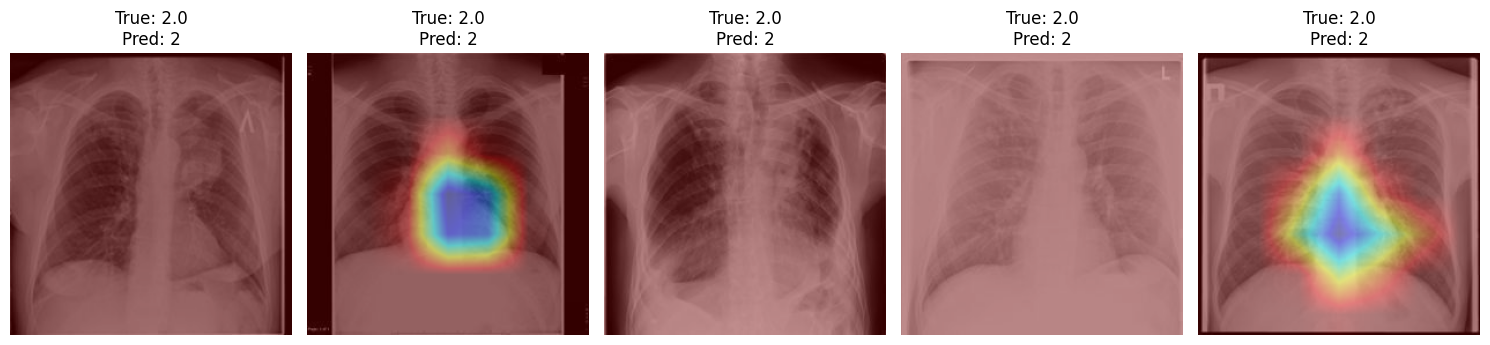

In [272]:
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, image_array, target_layer, class_index):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(target_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize heatmap
    return heatmap.numpy()

# Overlay Grad-CAM heatmap on the original image
def overlay_heatmap(heatmap, image_path, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, colormap)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# Get 5 random images per category and predict
def predict_and_visualize(df, model, target_layer, categories_col='category_encoded', image_path_col='image_path', n_images=5):
    categories = df[categories_col].unique()
    for category in categories:
        category_images = df[df[categories_col] == category][image_path_col].sample(n_images, random_state=42, replace=True)
        
        print(f"Category: {category}")
        plt.figure(figsize=(15, 10))
        
        for i, image_path in enumerate(category_images):
            try:
                preprocessed_img = preprocess_image(image_path)
                predicted_class = np.argmax(model.predict(preprocessed_img))
                
                # Generate Grad-CAM heatmap
                heatmap = generate_gradcam_heatmap(model, preprocessed_img, target_layer, predicted_class)
                
                # Overlay heatmap on the original image
                overlay_image = overlay_heatmap(heatmap, image_path)
                
                # Display the image
                plt.subplot(1, n_images, i + 1)
                plt.imshow(overlay_image)
                plt.axis('off')
                plt.title(f"True: {category}\nPred: {predicted_class}")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
        
        plt.tight_layout()
        plt.show()


# Apply function to visualize
predict_and_visualize(
    df=test_df_new.toPandas(),  # Convert Spark DataFrame to Pandas
    model=efficientnetb2_model,
    target_layer='conv5_block3_2_conv',  # Example target layer for ResNet101
    categories_col='category_encoded',
    image_path_col='image_path',
    n_images=5
)


## Tracking with Pandas UDF

In [ ]:
def process_images_udf(batch_df: pd.DataFrame) -> pd.DataFrame:
    results = []
    for _, row in batch_df.iterrows():
        try:
            image_path = row['image_path']
            true_label = row['category_encoded']
            
            # Preprocess image
            preprocessed_img = preprocess_image(image_path)
            
            # Predict
            predictions = efficientnetb2_model.predict(preprocessed_img)
            predicted_class = int(np.argmax(predictions))
            confidence = float(predictions[0, predicted_class])
            
            # Generate Grad-CAM
            heatmap = generate_gradcam_heatmap(
                efficientnetb2_model, 
                preprocessed_img, 
                target_layer="conv5_block3_2_conv", 
                class_index=predicted_class
            )
            overlay_image = overlay_heatmap(heatmap, image_path)
            
            # Save overlay
            overlay_path = f"gradcam/EfficientNetB2/{os.path.basename(image_path).replace('.jpg', '_gradcam.jpg')}"
            cv2.imwrite(overlay_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
            
            # Append results
            results.append({
                "image_path": image_path,
                "true_label": true_label,
                "predicted_class": predicted_class,
                "confidence": confidence,
                "gradcam_overlay_path": overlay_path
            })
        except Exception as e:
            print(f"Error processing image {row['image_path']}: {e}")
            results.append({
                "image_path": row['image_path'],
                "true_label": row['category_encoded'],
                "predicted_class": -1,  # Placeholder for errors
                "confidence": 0.0,
                "gradcam_overlay_path": "error"
            })
    return pd.DataFrame(results)

output_dfEff = process_images_udf(test_pd_dfEff) 

In [279]:
# Save the DataFrame to a CSV file
output_dfEff = spark.createDataFrame(output_dfEff)
output_dfEff.write.csv("gradcam/EfficientNetB2/CSV/", header=True, mode="overwrite")

# Print the DataFrame to the console
output_dfEff.show(truncate=False)

+--------------------------------------------+----------+---------------+------------------+-----------------------------------------------+
|image_path                                  |true_label|predicted_class|confidence        |gradcam_overlay_path                           |
+--------------------------------------------+----------+---------------+------------------+-----------------------------------------------+
|Chest X_Ray Dataset\COVID19\COVID19(103).jpg|3         |1              |0.8926270008087158|gradcam/EfficientNetB2/COVID19(103)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(105).jpg|3         |2              |0.8466391563415527|gradcam/EfficientNetB2/COVID19(105)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(140).jpg|3         |3              |0.85169517993927  |gradcam/EfficientNetB2/COVID19(140)_gradcam.jpg|
|Chest X_Ray Dataset\COVID19\COVID19(148).jpg|3         |1              |0.9759021401405334|gradcam/EfficientNetB2/COVID19(148)_gradcam.jpg|
|Chest X_Ray 

52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


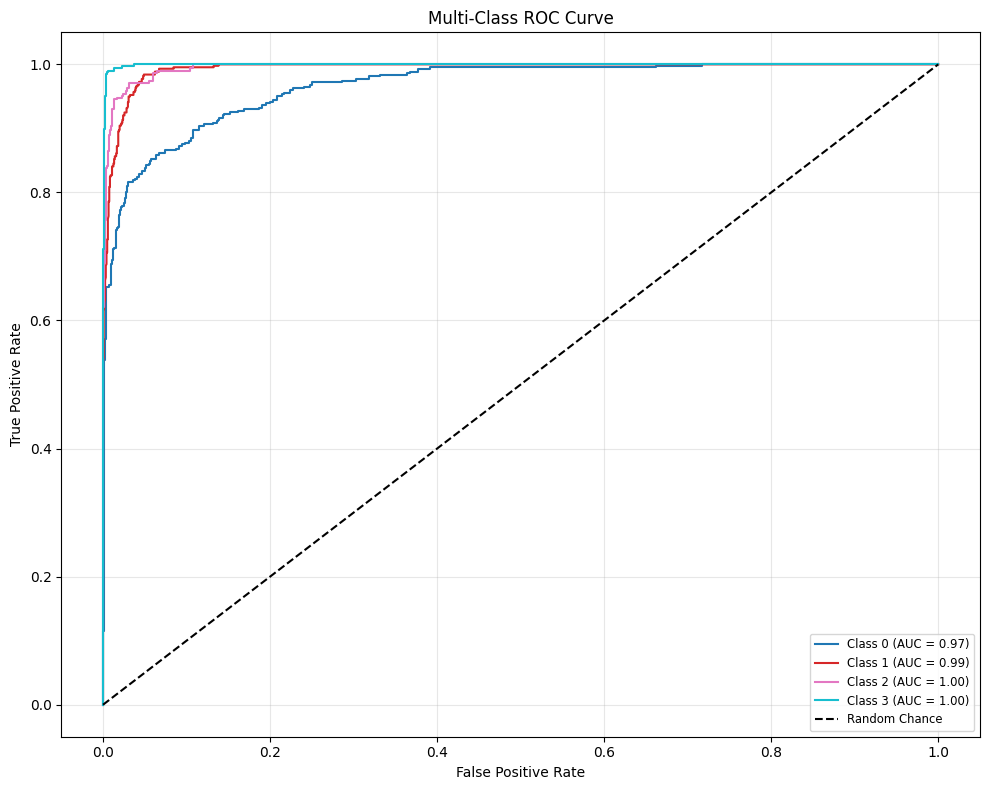

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Preprocess all test images
test_image_paths = test_pd_dfEff['image_path'].tolist()
test_images = np.array([preprocess_image(path) for path in test_image_paths])  # Preprocess all images
test_images = np.vstack(test_images)  # Stack into a batch

# Get true labels
true_labels = test_pd_dfEff['category_encoded'].to_numpy()

# Predict probabilities for all classes
predicted_probabilities = efficientnetb2_model.predict(test_images)  # Shape: (n_samples, n_classes)

# Number of categories
n_classes = predicted_probabilities.shape[1]

# Binarize the true labels for multi-class ROC
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(n_classes))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)  # Use a colormap with distinct colors for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})', color=colors(i))

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Configure the plot
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion on Model Accuracy
The model performance on the testing set is as follows:
- **VGG19:** Achieved an accuracy of 98.23% demonstrating excellent predicitve performance.
- **ResNet101:** Achieved an accuracy of 55.3%, which is relatively low.
- **EfficientNetB2:** Achieved an accuracy of 55.37%, similarly low compared to VGG19.

The performance of the three models—VGG19, ResNet101, and EfficientNetB2—on the testing set reveals significant differences in their predictive accuracy. VGG19 achieved an impressive accuracy of **98.23%**, indicating that it effectively captured the dataset's features and demonstrated excellent generalization. In contrast, ResNet101 and EfficientNetB2 performed similarly, with accuracy rates of **55.3%** and **55.37%**, respectively, which are only slightly better than random guessing for a balanced four-class classification problem. These results suggest that VGG19 significantly outperformed the other two models.

The superior performance of VGG19 can be attributed to its simpler, sequential architecture, which is well-suited to smaller or moderately complex datasets. Its straightforward design allows it to extract features effectively without requiring extensive preprocessing or a large volume of training data. The high accuracy indicates that it successfully learned the patterns and variations in the chest X-ray images necessary for accurate classification. On the other hand, the underwhelming performance of ResNet101 and EfficientNetB2 could be due to their more complex architectures, which are optimized for larger and more diverse datasets. These models likely struggled to generalize because they were underfitted, possibly due to inadequate training or insufficient data.


The disparity in performance might also be influenced by data preprocessing and augmentation techniques. While VGG19 may have been more robust to the dataset's transformations, ResNet101 and EfficientNetB2 typically require more extensive preprocessing and augmentation to prevent underfitting or over-reliance on local patterns. Furthermore, the training configuration, including hyperparameters such as learning rate, batch size, and optimizer choice, plays a crucial role in model performance. It is possible that the training setup was better optimized for VGG19 than for the other two models.

Another factor to consider is the size and diversity of the dataset. Small datasets are often better suited to simpler models like VGG19, as they require fewer examples to generalize effectively. In contrast, more complex models like ResNet101 and EfficientNetB2 need a larger and more diverse dataset to fully utilize their capacity and avoid underfitting. If the dataset lacked sufficient size or diversity, this could have further hampered the performance of the deeper architectures.
.



To improve the performance of ResNet101 and EfficientNetB2, it is recommended to enhance data preprocessing by applying robust augmentation techniques, such as flipping, rotation, or color adjustment, to increase dataset diversity. Additionally, hyperparameter tuning should be conducted using grid or random search to optimize the training process. Regularization techniques like dropout and weight decay could also help improve generalization. Finally, increasing the dataset size, either by collecting more data or employing advanced data augmentation, would provide a stronger foundation for training these complex models.

In summary, VGG19 outperformed ResNet101 and EfficientNetB2 primarily due to its compatibility with the dataset's size and complexity. The lower accuracy of the other two models highlights the challenges of training deep architectures on smaller datasets without sufficient augmentation or optimization. With additional preprocessing, tuning, and dataset expansion, their performance could potentially improve significantly.


## Recommendation
To further enhance this project and improve the predicitive performance of the models, several avenues of analysis and optimization can be explored. These incluse **Parameter adjustments, Classification by sub-categories** , and other advanced techniques to refine the models and insights derived from the dataset.

### Parameter Adjustment for Better Predictions
Fine-tuning model parameters is a critical step in improving accuracy and generalization. Adjusting the learning rate is essential, as it controls how quickly the model updates its weights during training. A learning rate that is too high may lead to overshooting the optimal point, while one that is too low can slow down training or result in suboptimal convergence. Using techniques like learning rate schedulers or cyclical learning rates can dynamically adapt the rate for improved performance. Similarly, experimenting with different batch sizes is important. Smaller batch sizes often lead to better generalization as the model sees more variation in each iteration, whereas larger batch sizes can stabilize training and reduce noise in gradient updates.

### Classification by Sub-Categories
Dividing the dataset into finer sub-categories can significantly enhance the model’s precision and provide more granular insights. For example, within the Pneumonia category, further classification into **bacterial pneumonia** and **viral pneumonia** can help the model learn specific patterns unique to each type. Similarly, Lung Opacity could be split into chronic opacity and acute opacity, which would allow the model to differentiate between long-term and short-term conditions.

### Data Augmentation
Data augmentation is a powerful method to improve generalization by increasing dataset diversity. Traditional augmentation techniques such as flipping, rotation, scaling, cropping, and color adjustments create variations of the original images, helping the model become robust to transformations. Adding **noise injection** mimics real-world image quality variations and further strengthens the model's ability to generalize.

More advanced augmentation techniques, such as using **Generative Adversarial Networks (GANs)**, can generate realistic synthetic images that augment underrepresented classes, balancing the dataset. Additionally, techniques like **Mixup** or **CutMix** combine features from multiple images to produce hybrid samples. These methods encourage the model to learn more generalized features, making it more resilient to noise and variations in the data. Employing such augmentation strategies can be particularly valuable when working with small datasets.

### Transfer Learning
Transfer learning provides an effective way to leverage pre-trained models, especially when the dataset is small. Models pre-trained on large-scale datasets like **ImageNet** or specialized datasets such as **ChestX-ray14** or **CheXpert** already capture fundamental visual features that can be adapted to this task. Fine-tuning these pre-trained models by training only the final layers allows the model to learn task-specific features while retaining the general feature extraction capabilities of earlier layers.

### Feature Engineering
Incorporating additional features can enhance the model’s understanding of the data. Texture analysis methods, such as extracting Haralick features, can capture subtle texture patterns within X-rays, which may be indicative of specific conditions. Similarly, analyzing intensity-based features, such as pixel intensity histograms, can help the model learn global and local variations in brightness and contrast, which are often diagnostic markers.

Applying edge-detection algorithms like Sobel or Canny can highlight structural features, such as the shape and boundaries of the lungs, which are critical in identifying abnormalities. Combining these handcrafted features with the deep features learned by the model can result in a hybrid approach, enriching the representation of the data. 